# 5. Score-Based Generative Model (Noise Conditional Score Network)

## 1. Training Stage

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)
    
num_categories = {}
for column in hts_df.columns:
    num_unique = hts_df[column].nunique()
    num_categories[column] = num_unique
    print(f"Column '{column}' has {num_unique} unique categories.")

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.


In [3]:
def dequantize_data(data):
    data_continuous = data.copy().astype(float)
    for column in data_continuous.columns:
        data_continuous[column] += np.random.uniform(0, 1, size=data_continuous.shape[0])
    return data_continuous

data_continuous = dequantize_data(hts_df)
data_tensor = torch.tensor(data_continuous.values, dtype=torch.float32).to(device)

In [10]:
# Define the score network
class ScoreNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, sigma_min=0.002, sigma_max=25, num_sigma=40):
        super(ScoreNetwork, self).__init__()
        self.input_dim = input_dim
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.num_sigma = num_sigma
        self.sigmas = torch.exp(torch.linspace(
            np.log(self.sigma_max), np.log(self.sigma_min), self.num_sigma)).to(device)

        # Neural network architecture
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, sigma):
        # Concatenate sigma as an additional feature
        sigma_feature = sigma.view(-1, 1)
        x_sigma = torch.cat([x, sigma_feature], dim=1)
        score = self.net(x_sigma)
        return score

    def loss_fn(self, x):
        total_loss = 0.0
        for sigma in self.sigmas:
            sigma = sigma.to(device)
            sigma = sigma.expand(x.size(0), 1)
            noise = torch.randn_like(x) * sigma
            x_noisy = x + noise
            score = self.forward(x_noisy, sigma)
            loss = ((score + noise / (sigma ** 2)) ** 2).mean() # Equation (4.6)
            total_loss += loss
        return total_loss

    def annealed_langevin_dynamics(self, num_samples, num_steps_each=100, step_size=0.01):
        x = torch.randn(num_samples, self.input_dim).to(device)
        self.eval()
        with torch.no_grad():
            for sigma in self.sigmas:
                sigma = sigma.to(device)
                for _ in range(num_steps_each):
                    x.requires_grad_(True)
                    sigma = sigma.expand(x.size(0), 1)
                    score = self.forward(x, sigma)
                    grad = score
                    x = x + (step_size * grad) + torch.randn_like(x) * np.sqrt(2 * step_size)
                    x = x.detach()
        return x.cpu().numpy()

In [15]:
# Training code
hidden_dim = 512
input_dim = data_tensor.shape[1]

score_model = ScoreNetwork(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

In [16]:
learning_rate = 1e-4
batch_size = 512
num_epochs = 5

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(score_model.parameters(), lr=learning_rate)

score_model.train()
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        loss = score_model.loss_fn(x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    epoch_loss /= len(dataset)
    if epoch % 1 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.6f}')

Epoch [1/5], Loss: 652958.567760
Epoch [2/5], Loss: 650408.814140
Epoch [3/5], Loss: 651216.806120
Epoch [4/5], Loss: 651165.911940
Epoch [5/5], Loss: 652212.606740


## 2. Testing Stage

In [17]:
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples = 3000

# Sampling new data using Annealed Langevin Dynamics
samples = score_model.annealed_langevin_dynamics(num_samples, num_steps_each=100, step_size=0.01)

# Post-process samples to obtain categorical values
columns = hts_df.columns.tolist()
generated_categories = pd.DataFrame(samples, columns=columns)
for column in columns:
    max_cat = num_categories[column] - 1
    generated_categories[column] = np.floor(generated_categories[column]).astype(int)
    generated_categories[column] = np.clip(generated_categories[column], 0, max_cat)

<ipython-input-18-9278670d96d1>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)


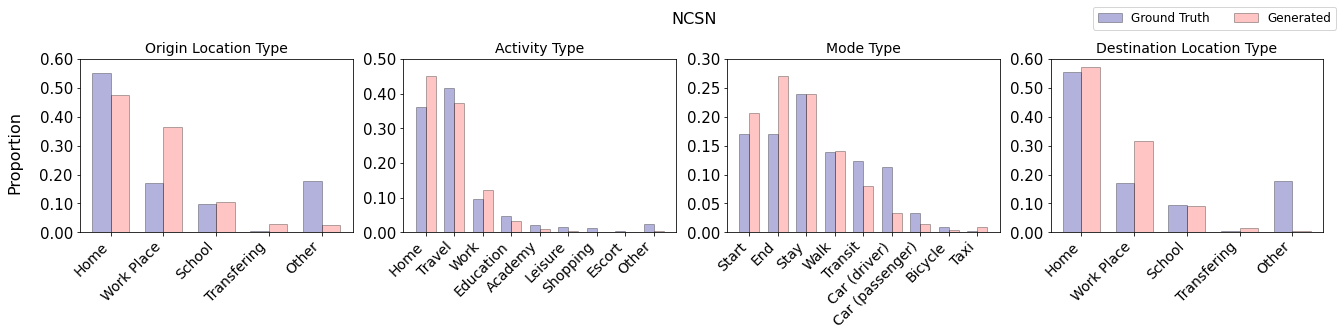

In [18]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']

fig, axs = plt.subplots(1, 4, figsize=(18, 3))

formatter = FormatStrFormatter('%.2f')

fig.tight_layout(h_pad=1, w_pad=2)

ylim_list = [0.60, 0.5, 0.3, 0.6]
sub_title_list = ['Origin Location Type', 'Activity Type', 'Mode Type', 'Destination Location Type']
bar_width = 0.35
offset = bar_width / 2

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

for column, ylim, sub_title, xtick_labels, ax in zip(columns, ylim_list, sub_title_list, xtick_labels_list, axs.flatten()):
    
    # Ground truth
    unique_hts, counts_hts = np.unique(hts_df[column], return_counts=True)
    ax.set_ylim([0, ylim])
    positions_hts = np.arange(len(unique_hts))
    ax.bar(positions_hts - offset, counts_hts / counts_hts.sum(), 
           width=bar_width, color='#00008F', edgecolor='black', alpha=0.3, label='Ground Truth')
    
    # Generated data
    unique_gen, counts_gen = np.unique(generated_categories[column], return_counts=True)
    positions_gen = np.arange(len(unique_gen))
    ax.bar(positions_gen + offset, counts_gen / counts_gen.sum(), 
           width=bar_width, color='#FF4040', edgecolor='black', alpha=0.3, label='Generated')
    
    ax.set_xticks([int(x) for x in unique_hts])
    ax.set_xticklabels(xtick_labels, fontsize=14, rotation=45, ha='right')
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)

    ax.set_title(sub_title, fontsize=14)

fig.suptitle('NCSN', fontsize=16, y=1.15)
fig.text(-0.03, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=16)

fig.legend(['Ground Truth', 'Generated'], loc='upper right', ncol=2, fontsize=12, 
           bbox_to_anchor=(1, 1.2), bbox_transform=fig.transFigure)

plt.savefig(f'ncsn_discrete.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()